In [3]:
import numpy as np
from seaborn import color_palette
from skimage import io
import re
import pandas as pd
import seaborn as sns
from skimage.measure import regionprops_table
from matplotlib import pyplot as plt
from pathlib import Path
import json
from copy import copy
from pprint import pprint

In [10]:
def get_image(configfile, stem):
    with open(configfile) as f:
        config = json.load(f)
        
        for exp in config['experiments']:
            for img in exp['images']:
                if img['stem'] == stem:
                    print(f"{img['stem']}: {img['segment']} {img['detect_spots']}")
                    return img


In [139]:
# bad picture
mrna = 'rpoD'
configfile = '/Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp22/config-detection-processed.json'
stem = 'exp22-GAL_07'     

In [178]:
# good picture (good signal but segmentation leaves legit cells out)
mrna = 'rpoD'
configfile = '/Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp22/config-detection-processed.json'
stem = 'exp22-GLU-r02'     

In [99]:
# even better picture (good signal and full segmentation)
mrna = 'rpoD'
configfile = '/Volumes/Flodrive/Florence/smFISH/analysis/20240927-exp16/config-detection-processed.json'
stem = 'MG1655_GLU_OD_0.3_left_02'  


In [100]:
img = get_image(configfile, stem)


MG1655_GLU_OD_0.3_left_02: True True


In [126]:
spots = np.load(img[mrna]['spotsfile'])
spots

array([[   14,   204,   160,  7499,   896,  1433],
       [   14,   266,   256,  9332,  1819,  1501],
       [   14,   286,   799, 13579,  4131,  1522],
       ...,
       [   19,  1094,   481, 12343,  5224,  2350],
       [   19,  1134,   453,  7995,  2133,  2392],
       [   20,  1133,   169,  7763,  2607,  2391]])

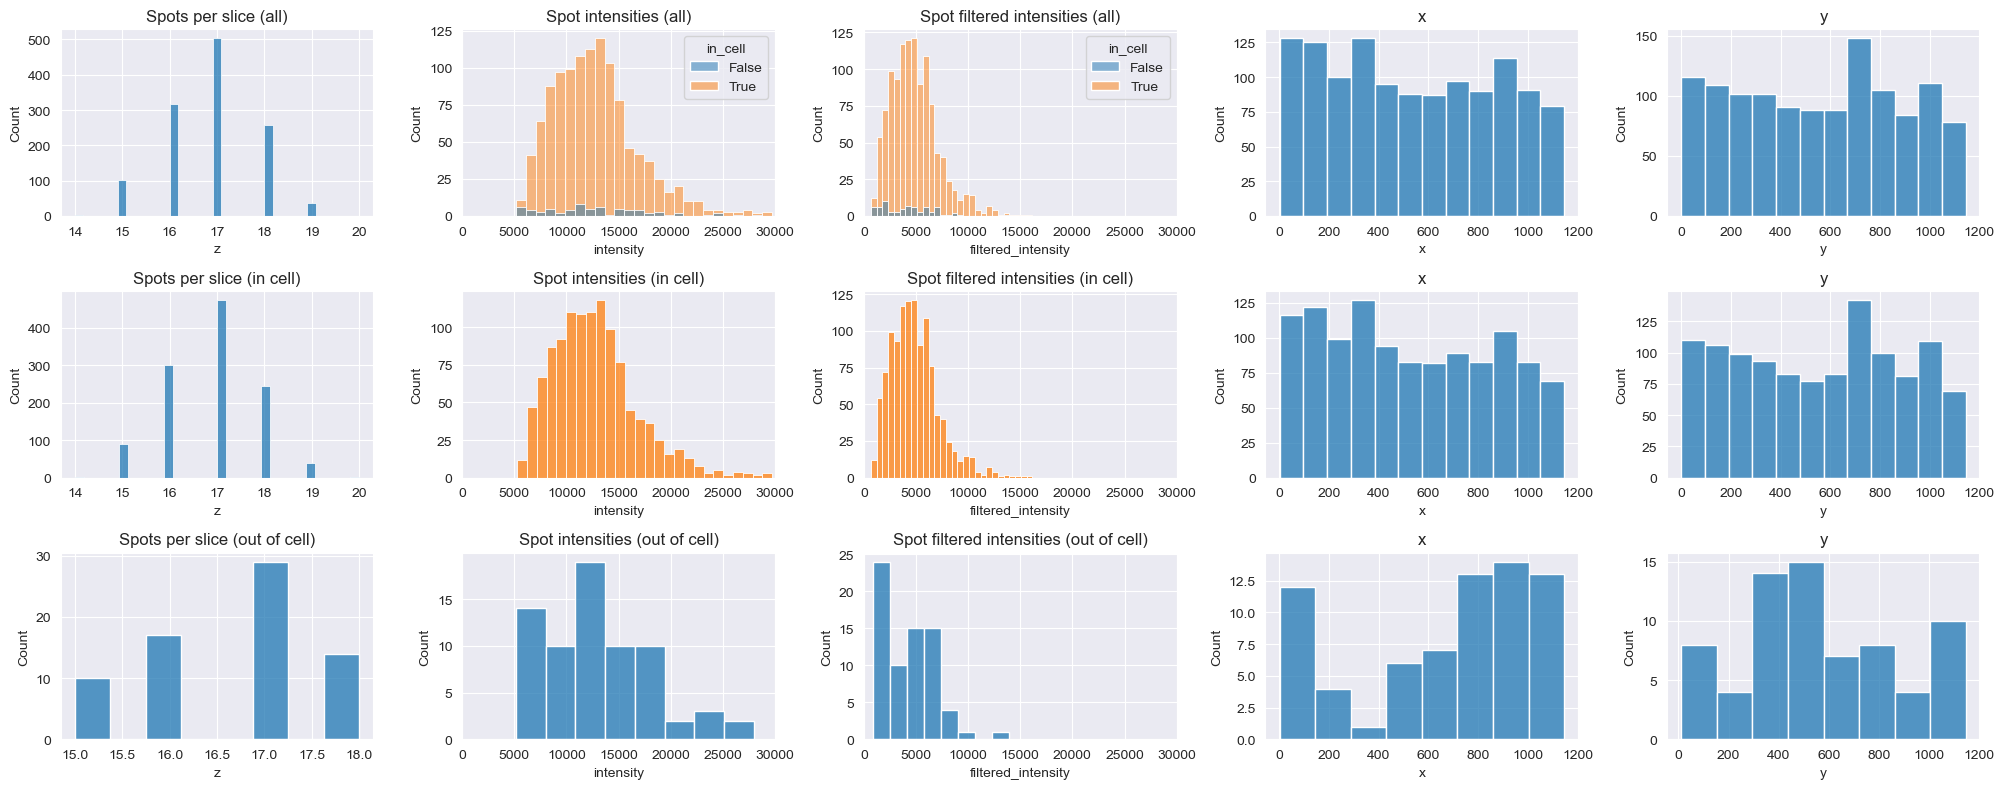

In [152]:


spots = pd.DataFrame(np.load(img[mrna]['spotsfile']), columns=['z', 'y', 'x', 'intensity', 'filtered_intensity', 'label'])
spots['in_cell'] = spots.apply(lambda s: False if s['label'] == 0 else True, axis=1)

fig, ax = plt.subplots(3, 5, figsize=(20, 8))
sns.histplot(spots, x='z', ax=ax[0][0]).set(title='Spots per slice (all)')
sns.histplot(spots, x='intensity', hue='in_cell', ax=ax[0][1]).set(title='Spot intensities (all)', xlim=(0, 30000))
sns.histplot(spots, x='filtered_intensity', hue='in_cell', ax=ax[0][2]).set(title='Spot filtered intensities (all)', xlim=(0, 30000))
sns.histplot(spots, x='x', ax=ax[0][3]).set(title='x')
sns.histplot(spots, x='y', ax=ax[0][4]).set(title='y')

sns.histplot(spots.query('label > 0'), x='z', ax=ax[1][0]).set(title='Spots per slice (in cell)')
sns.histplot(spots.query('label > 0'), x='intensity', color=sns.color_palette()[1], ax=ax[1][1]).set(title='Spot intensities (in cell)', xlim=(0, 30000))
sns.histplot(spots.query('label > 0'), x='filtered_intensity', color=sns.color_palette()[1], ax=ax[1][2]).set(title='Spot filtered intensities (in cell)', xlim=(0, 30000))
sns.histplot(spots.query('label > 0'), x='x', ax=ax[1][3]).set(title='x')
sns.histplot(spots.query('label > 0'), x='y', ax=ax[1][4]).set(title='y')

sns.histplot(spots.query('label == 0'), x='z', ax=ax[2][0]).set(title='Spots per slice (out of cell)')
sns.histplot(spots.query('label == 0'), x='intensity', color=sns.color_palette()[0], ax=ax[2][1]).set(title='Spot intensities (out of cell)', xlim=(0, 30000))
sns.histplot(spots.query('label == 0'), x='filtered_intensity', color=sns.color_palette()[0], ax=ax[2][2]).set(title='Spot filtered intensities (out of cell)', xlim=(0, 30000))
sns.histplot(spots.query('label == 0'), x='x', ax=ax[2][3]).set(title='x')
sns.histplot(spots.query('label == 0'), x='y', ax=ax[2][4]).set(title='y')

plt.tight_layout();


In [129]:
len(spots.query('label == 0')), len(spots.query('label > 0'))

(70, 1152)

In [151]:
sns.color_palette()[:2]

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725)]

#### This does not work very well
1. The intensities of the cells that don't have a mask despite being legitimate cells 
count as out-of-cells intensities.
2. Where the DIC is misaligned (top right corner), spots will be erroneously counted as out of cells.

In [113]:
spot_intensities.query('label > 0')

,z,y,x,intensity,filtered_intensity,label
0,14,17,455,6155,1039,26
1,14,23,440,11599,3319,8
2,14,35,384,11154,3436,53
3,14,64,1922,6807,1089,77
4,14,84,391,8336,1972,110
...,...,...,...,...,...,...
5171,20,2280,169,7763,2607,2391
5172,21,1498,1156,12656,4090,1603
5173,22,31,488,10088,3179,48
5174,22,2043,1615,12541,4433,2159


In [114]:
spot_intensities.query('label == 0')

,z,y,x,intensity,filtered_intensity,label
8,14,144,2185,7076,1905,0
11,14,202,1557,5154,1154,0
13,14,256,190,5362,1326,0
14,14,265,467,5284,1074,0
16,14,387,2098,7077,1126,0
...,...,...,...,...,...,...
5127,19,2063,1611,19678,9287,0
5144,19,2148,2252,6094,2216,0
5150,19,2198,2141,6985,1713,0
5159,19,2274,1769,6414,1713,0


In [153]:
spots

,z,y,x,intensity,filtered_intensity,label,in_cell
0,14,204,160,7499,896,1433,True
1,14,266,256,9332,1819,1501,True
2,14,286,799,13579,4131,1522,True
3,15,3,173,12767,4410,1211,True
4,15,7,427,11205,3644,1209,True
...,...,...,...,...,...,...,...
1217,19,1031,2,8337,2657,2301,True
1218,19,1031,141,11866,4214,2297,True
1219,19,1094,481,12343,5224,2350,True
1220,19,1134,453,7995,2133,2392,True


In [162]:
cycle = ['cyan', 'red'] if spots.iloc[0]['in_cell'] == True else ['red', 'cyan']

In [161]:
spots.iloc[0]

z                       14
y                      204
x                      160
intensity             7499
filtered_intensity     896
label                 1433
in_cell               True
Name: 0, dtype: object

In [159]:
type(spots)

pandas.core.frame.DataFrame